### Timeseries Analysis using NDVI over selected Area

#### Importing of libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import geopandas as gpd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

#### Loading of functions to use 

In [2]:
def read_band(href):
    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        return ds.read(1, window=aoi_window)

In [3]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

In [4]:
def get_band(ds, band_name):
    return read_band(pc.sign(find_asset_by_band_common_name(ds, band_name).href)).astype(float)

#### Selecting of Area of Interest using a vector file

In [5]:
area_of_interest = gpd.read_file('data/fiji_test.geojson')

#### Displaying Area of interest on a map

In [6]:
area_of_interest.explore(column=area_of_interest.columns[0])

####  Loading of data from the Planetary API Stac

In [7]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
time_of_interest = "2019-01-01/2020-12-31"

search = catalog.search(
    collections=["landsat-8-c2-l2"],
    intersects=area_of_interest.geometry[0],
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 50}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 25 Items


#### Selecting the best Image with least cloud cover 

In [8]:
least_cloudy_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]
red = get_band(least_cloudy_item, 'red')
blue = get_band(least_cloudy_item, 'blue')
green = get_band(least_cloudy_item, 'green')
multiband_data = np.stack([red, blue, green])

#### Displaying th RGB image

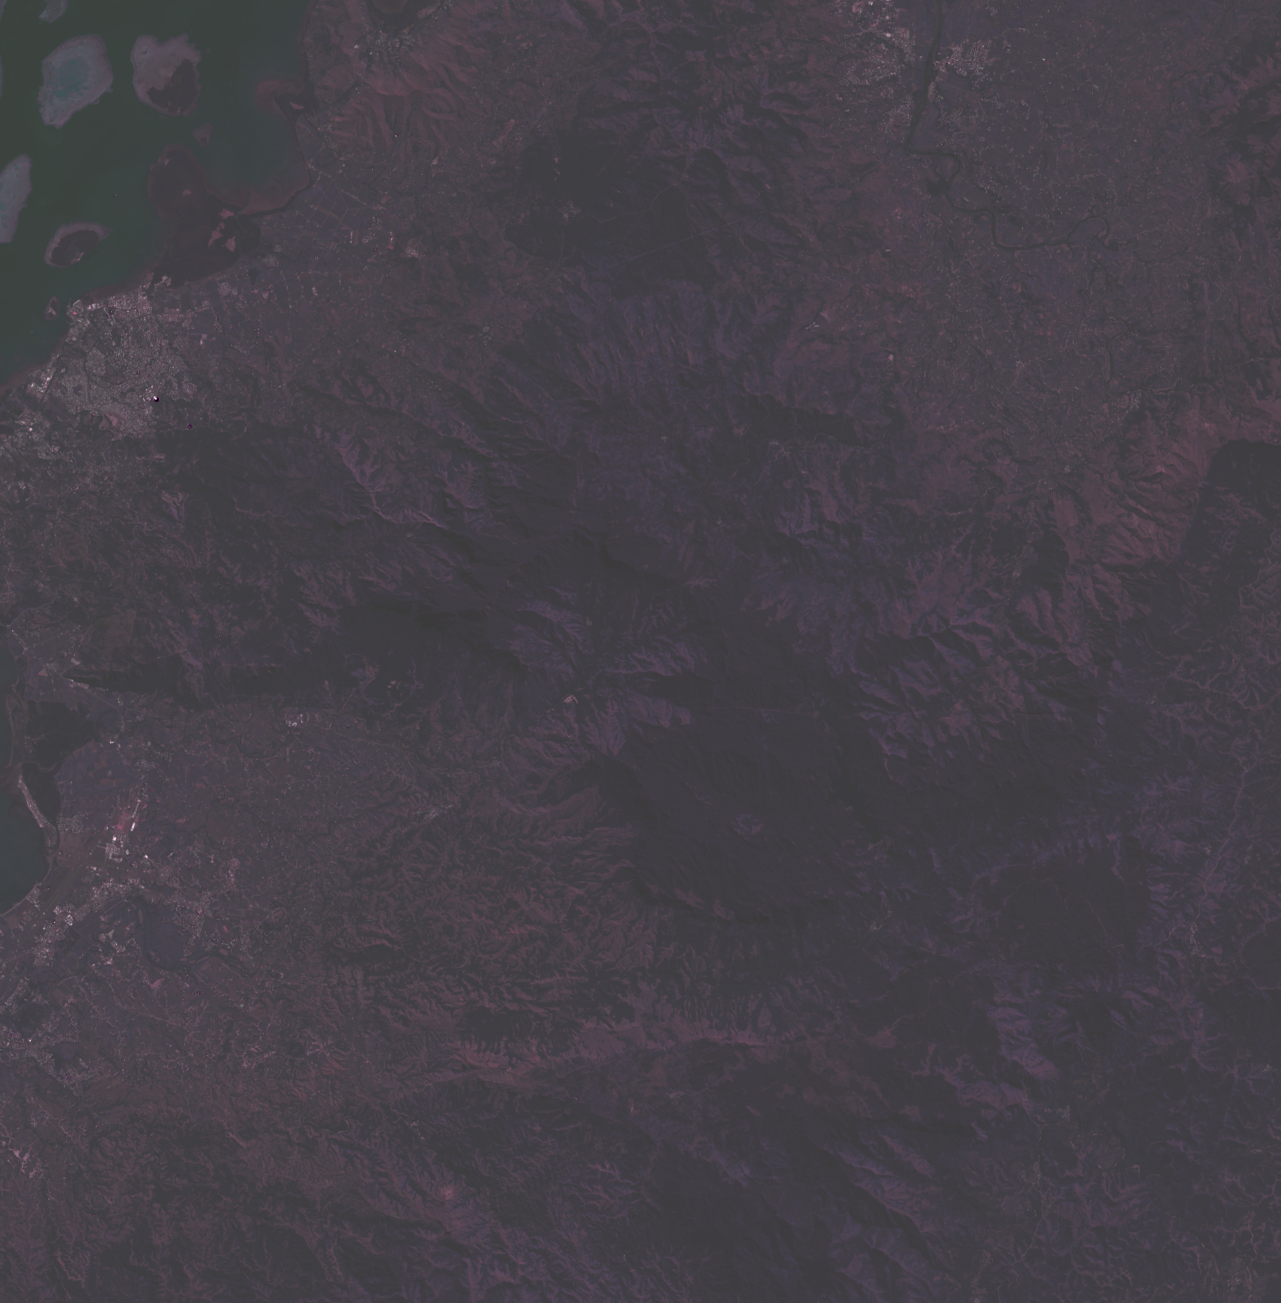

In [9]:
rescaled = multiband_data.astype(float)
min_value, max_value = rescaled.min(), rescaled.max()
rescaled = ((rescaled - min_value) * 255) / (max_value - min_value)
byte_data = rescaled.astype("ubyte")
Image.fromarray(np.transpose(byte_data, axes=[1, 2, 0]))

#### Processing and plotting of NDVI timeseries 

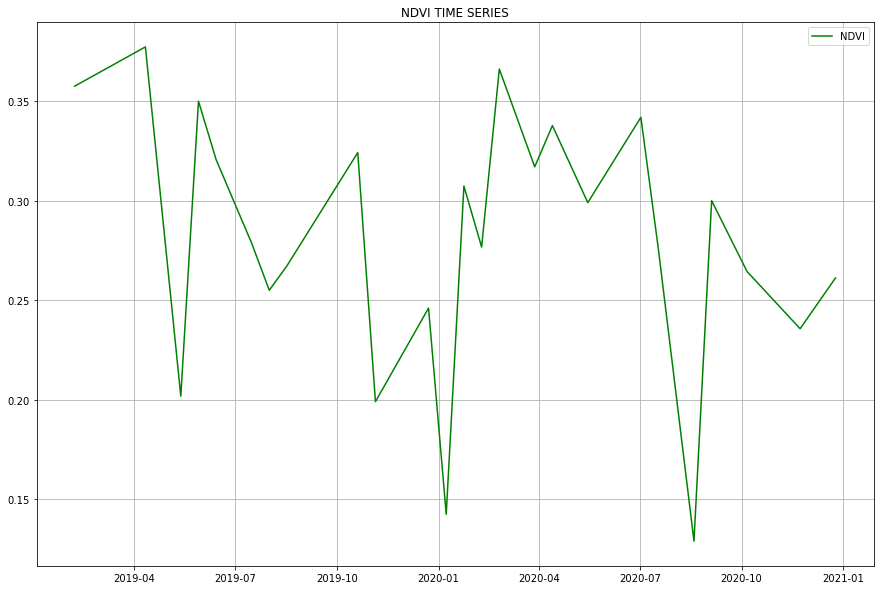

In [10]:
date = []
mean_ndvi = []
mean_max = 0
plt_ndvi = 0
for image in items:
    date.append(image.datetime)
    red = get_band(image, 'red')
    nir = get_band(image, 'nir08')
    
    NDVI = (nir - red) / (nir + red)

    ndvi_matrix = np.matrix(NDVI)
    mean_ndvi.append(ndvi_matrix.mean())
    
    if mean_max > ndvi_matrix.mean():
        plt_ndvi = NDVI
    mean_max = ndvi_matrix.mean()
    
fig = figure(figsize=(15, 10), frameon=True)
plt.plot(date, mean_ndvi, color= 'green',label='NDVI')
plt.legend(loc='best')
plt.title("NDVI TIME SERIES")
plt.grid()
plt.show()

#### Plot the Max NDVI Values

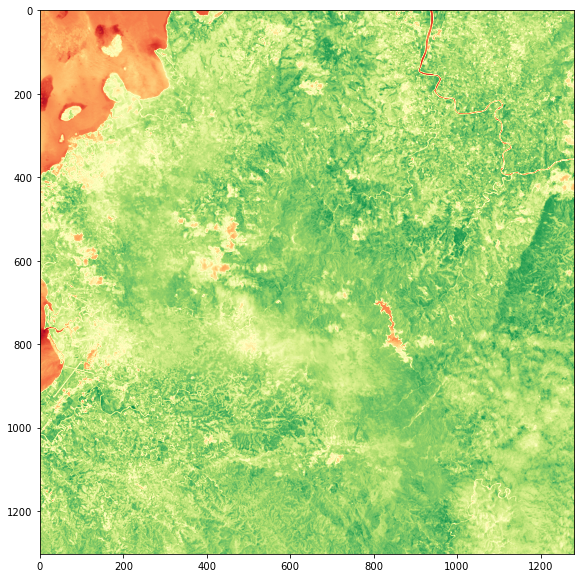

In [11]:
fig = figure(figsize=(10, 10), frameon=True)
plt.imshow(plt_ndvi, cmap="RdYlGn")